# Amazon Bedrock(Titan 다중 모드 임베딩)와 Amazon OpenSearch  사용하여 제품 추천을 위한 컨텍스트 기반 텍스트 및 이미지 검색

제시된 솔루션은 텍스트 또는 이미지 쿼리를 기반으로 제품을 검색하고 추천하기 위한 Amazon Titan 다중 모드 임베딩 모델 기반 검색 엔진 프로토타입을 구축하는 구현 방법을 제공합니다. 이는 [Amazon Bedrock Titan 모델](https://aws.amazon.com/bedrock/titan)을 사용하여 이미지와 텍스트를 임베딩으로 인코딩하고, OpenSearch Service의 [k-최근접 이웃(KNN) 기능](https://docs.aws.amazon.com/opensearch-service/latest/developerguide/knn.html)을 사용하여 인덱스를 쿼리하는 단계별 가이드입니다.

# 1. 환경 설정

## Python Package 설치

In [1]:
# install_needed = True
install_needed = False

if install_needed:
    !pip install opensearch-py==2.5.0
    # !pip install requests-aws4auth
    !pip install -U boto3==1.34.87
    !pip install -U botocore==1.34.87
    !pip install -U awscli
    !pip install seaborn
    !pip install s3fs==2024.3.1 

In [2]:
! pip list | grep -E "boto|opensearch-py|s3fs"

aiobotocore                           2.7.0
boto3                                 1.34.87
botocore                              1.34.87
opensearch-py                         2.5.0
s3fs                                  2024.3.1


## 사용자 라이브러리 사용 경로 설정

In [3]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = ".."
add_python_path(module_path)


python path: /home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/06_multi_modal_image_search is added
sys.path:  ['/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/06_multi_modal_image_search/notebook', '/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/opt/conda/lib/python3.10/site-packages', '/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/06_multi_modal_image_search']


## Bedrock Boto3 Client 생성

In [4]:
import boto3
import pandas as pd
import os
import re
import boto3
import json
import time
import base64
import logging
import numpy as np
import seaborn as sns
from PIL import Image
from io import BytesIO


from tqdm import tqdm
from urllib.parse import urlparse
from multiprocessing.pool import ThreadPool

from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth, helpers

In [5]:
# getting boto3 clients for required AWS services
sts_client = boto3.client('sts')
s3_client = boto3.client('s3')
# aoss_client = boto3.client('opensearchserverless')

bedrock_client = boto3.client(
    "bedrock-runtime", 
    "us-east-1", 
    endpoint_url="https://bedrock-runtime.us-east-1.amazonaws.com"
)

In [6]:
session = boto3.session.Session()
region_name = session.region_name
account_id = sts_client.get_caller_identity()["Account"]
region_name, account_id

('us-east-1', '057716757052')

## 2. Load publically available dataset

Amazon Berkeley Objects Dataset을 사용하고 있습니다. 이 데이터셋은 다국어 메타데이터와 398,212개의 고유 카탈로그 이미지를 포함한 147,702개의 제품 목록으로 구성되어 있습니다. 8,222개의 목록에는 턴테이블 사진이 포함되어 있습니다. 여기서는 제품 이미지와 영어로 된 제품 이름(제품의 간단한 설명으로 간주)만 사용할 것입니다. 데모를 위해 약 1,600개의 제품을 사용할 예정입니다.

### 2.1 데이터 준비 및 확인 

메타데이터 로드

pandas를 사용하여 메타데이터를 로드한 다음, 데이터프레임에서 영어 제목을 가진 제품을 선택할 수 있습니다. 나중에 main_image_id라는 열을 사용하여 제품 이름과 제품 이미지를 병합할 것입니다.

In [7]:
meta = pd.read_json("s3://amazon-berkeley-objects/listings/metadata/listings_0.json.gz", lines=True)
def func_(x):
    us_texts = [item["value"] for item in x if item["language_tag"] == "en_US"]
    return us_texts[0] if us_texts else None

meta = meta.assign(item_name_in_en_us=meta.item_name.apply(func_))
meta = meta[~meta.item_name_in_en_us.isna()][["item_id", "item_name_in_en_us", "main_image_id"]]
print(f"#products with US English title: {len(meta)}")
meta.head()

#products with US English title: 1655


,item_id,item_name_in_en_us,main_image_id
7,B0896LJNLH,AmazonBasics Serene 16-Piece Old Fashioned and...,61izEZdhlaL
18,B07HCR1LSQ,[Find] Amazon Collection Platinum Plated Sterl...,61kDp2x8tPL
22,B075DQBBJZ,Arizona Desert Sand Horizon Photo with Wood Ha...,91IjyKZ76qL
38,B07S74D9T7,AmazonBasics Adjustable Speaker Stand - 3.8 to...,71x4c-BafpL
39,B01N27SMXC,Amazon Brand - The Fix Women's Foley Tassel Sl...,71-eMu0gN+L


데이터프레임에서 1600개 이상의 제품을 볼 수 있어야 합니다.
다음으로 제품 이름과 제품 이미지를 연결할 수 있습니다. `images/metadata/images.csv.gz`에는 이미지 메타데이터가 포함되어 있습니다. 이 파일은 gzip으로 압축된 CSV 파일로, `image_id`, `height`, `width`, `path` 열이 있습니다. 메타데이터 파일을 읽은 다음 제품 메타데이터와 병합할 수 있습니다.

In [8]:
image_meta = pd.read_csv("s3://amazon-berkeley-objects/images/metadata/images.csv.gz")
dataset = meta.merge(image_meta, left_on="main_image_id", right_on="image_id")

In [9]:
# Create a new column in dataset with FULL PATH of the image
dataset = dataset.assign(img_full_path=f's3://amazon-berkeley-objects/images/small/' + dataset.path.astype(str))
dataset

,item_id,item_name_in_en_us,main_image_id,image_id,height,width,path,img_full_path
0,B0896LJNLH,AmazonBasics Serene 16-Piece Old Fashioned and...,61izEZdhlaL,61izEZdhlaL,1197,894,07/075e5d67.jpg,s3://amazon-berkeley-objects/images/small/07/0...
1,B07HCR1LSQ,[Find] Amazon Collection Platinum Plated Sterl...,61kDp2x8tPL,61kDp2x8tPL,1000,1000,c9/c923418f.jpg,s3://amazon-berkeley-objects/images/small/c9/c...
2,B075DQBBJZ,Arizona Desert Sand Horizon Photo with Wood Ha...,91IjyKZ76qL,91IjyKZ76qL,2560,2560,c6/c6889ed4.jpg,s3://amazon-berkeley-objects/images/small/c6/c...
3,B07S74D9T7,AmazonBasics Adjustable Speaker Stand - 3.8 to...,71x4c-BafpL,71x4c-BafpL,2560,2560,2b/2b90e918.jpg,s3://amazon-berkeley-objects/images/small/2b/2...
4,B01N27SMXC,Amazon Brand - The Fix Women's Foley Tassel Sl...,71-eMu0gN+L,71-eMu0gN+L,704,1770,2c/2c0416de.jpg,s3://amazon-berkeley-objects/images/small/2c/2...
...,...,...,...,...,...,...,...,...
1644,B07JCDQWM6,Amazon Brand – Rivet Thomas Modern Leather Sof...,71e51Rb1h4L,71e51Rb1h4L,2560,2560,c4/c4c46850.jpg,s3://amazon-berkeley-objects/images/small/c4/c...
1645,B07B1LZQWL,"Salmon Cake with Confetti Grains, 12.17 oz",91qFxcWDtjL,91qFxcWDtjL,1982,2560,01/0111c309.jpg,s3://amazon-berkeley-objects/images/small/01/0...
1646,B073P17SZZ,Amazon Brand – Rivet Blue Ocean Waves Print Wa...,91NCaDVKPEL,91NCaDVKPEL,1719,2560,85/85d5420a.jpg,s3://amazon-berkeley-objects/images/small/85/8...
1647,B07JQX8S2X,Amazon Basics Tufted Outdoor Square Seat Patio...,91XM523rZgL,91XM523rZgL,2560,2560,45/45e8e821.jpg,s3://amazon-berkeley-objects/images/small/45/4...


다음 코드를 실행하여 데이터셋에서 한 개의 샘플 이미지를 확인할 수 있습니다.

In [10]:
from search_utils.utils import (
            get_image_from_item_id_s3,
            get_titan_multimodal_embedding,
            find_similar_items_from_query,
            find_similar_items_from_image,
            display_images,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


AmazonBasics Serene 16-Piece Old Fashioned and Coolers Glass Drinkware Set


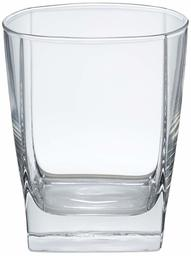

In [11]:
image, item_name = get_image_from_item_id_s3(item_id = "B0896LJNLH", dataset = dataset, 
                    image_path = f's3://amazon-berkeley-objects/images/small/' )
print(item_name)
image

# 3. 제품 이미지에서 임베딩 생성

Amazon Titan 다중 모드 임베딩 G1(1세대)은 이미지와 텍스트를 동일한 잠재 공간에 투영할 수 있으므로, 제품 이미지나 텍스트를 임베딩 공간에 인코딩하기만 하면 됩니다. 이 실습에서는 [배치 추론](https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference.html)을 사용하여 제품 이미지를 인코딩할 수 있습니다. 작업을 생성하기 전에 Amazon Berkeley Objects Dataset 공개 S3 버킷에서 자신의 S3 버킷으로 제품 이미지를 복사해야 합니다. 이 작업은 10분 이내에 완료됩니다.

그러나 이 노트북에서는 배치 추론 대신 실시간 API를 사용할 것입니다.

In [12]:
%%time
multimodal_embeddings_img = []

for idx, path in enumerate(dataset['img_full_path']):
    embedding = get_titan_multimodal_embedding(image_path=path, dimension=1024)["embedding"]
    multimodal_embeddings_img.append(embedding)

dataset = dataset.assign(embedding_img=multimodal_embeddings_img)

CPU times: user 47.7 s, sys: 1.31 s, total: 49 s
Wall time: 5min 59s


In [13]:
dataset.head()

,item_id,item_name_in_en_us,main_image_id,image_id,height,width,path,img_full_path,embedding_img
0,B0896LJNLH,AmazonBasics Serene 16-Piece Old Fashioned and...,61izEZdhlaL,61izEZdhlaL,1197,894,07/075e5d67.jpg,s3://amazon-berkeley-objects/images/small/07/0...,"[0.018173315, 0.003140607, -0.05283171, -0.014..."
1,B07HCR1LSQ,[Find] Amazon Collection Platinum Plated Sterl...,61kDp2x8tPL,61kDp2x8tPL,1000,1000,c9/c923418f.jpg,s3://amazon-berkeley-objects/images/small/c9/c...,"[0.028592803, 0.00036926294, -0.03403905, -0.0..."
2,B075DQBBJZ,Arizona Desert Sand Horizon Photo with Wood Ha...,91IjyKZ76qL,91IjyKZ76qL,2560,2560,c6/c6889ed4.jpg,s3://amazon-berkeley-objects/images/small/c6/c...,"[0.04700583, -0.017044099, 0.008791166, -0.010..."
3,B07S74D9T7,AmazonBasics Adjustable Speaker Stand - 3.8 to...,71x4c-BafpL,71x4c-BafpL,2560,2560,2b/2b90e918.jpg,s3://amazon-berkeley-objects/images/small/2b/2...,"[-0.019421993, -0.00037442896, -0.017875964, -..."
4,B01N27SMXC,Amazon Brand - The Fix Women's Foley Tassel Sl...,71-eMu0gN+L,71-eMu0gN+L,704,1770,2c/2c0416de.jpg,s3://amazon-berkeley-objects/images/small/2c/2...,"[0.010319183, 0.0054898052, -0.017583888, -0.0..."


## JSON 파일에 데이터 저장

In [16]:
from search_utils.utils import (
                        save_dataset_to_json,
                        load_json_pandas_dataset,
                        plot_similarity_heatmap,
)

save_path = "../data/berkely/berkely_image_embedding.json"

save_dataset_to_json(save_path, dataset)    
loaded_json_berkely = load_json_pandas_dataset(save_path)
loaded_json_berkely.tail(2)



../data/berkely/berkely_image_embedding.json is saved


,item_id,item_name_in_en_us,main_image_id,image_id,height,width,path,img_full_path,embedding_img
1647,B07JQX8S2X,Amazon Basics Tufted Outdoor Square Seat Patio...,91XM523rZgL,91XM523rZgL,2560,2560,45/45e8e821.jpg,s3://amazon-berkeley-objects/images/small/45/4...,"[-0.052831195000000004, -0.016111642000000002,..."
1648,B074MG76KH,"365 Everyday Value, Daily Shower Cleaner, 32 f...",71c2Ny+WfoL,71c2Ny+WfoL,2560,1143,9f/9fefdb9d.jpg,s3://amazon-berkeley-objects/images/small/9f/9...,"[-0.047227167, 0.013820353, 0.009427128, -0.07..."


## 3.1 이미지 임베딩을 가시화 
- 샘플 수 (예: 20개) 가 서로 얼마나 유사한지를 확인 해봄.
- 아래에서 0번째 샘플은 5번째 샘플과 유사함을 보여 주고 있음

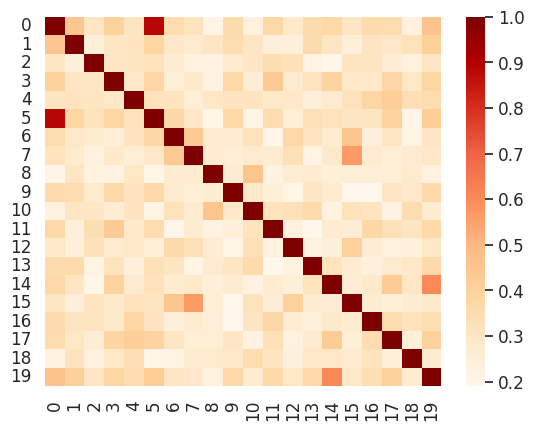

In [17]:
plot_similarity_heatmap(multimodal_embeddings_img[:20], multimodal_embeddings_img[:20])

## 4. OpenSearch Index 에 데이터 저장

## OpenSearch 연결 세팅

In [18]:
from search_utils.proc_docs import get_parameter

In [19]:
import boto3
ssm = boto3.client('ssm', 'us-east-1')

opensearch_domain_endpoint = get_parameter(
    boto3_clinet = ssm,
    parameter_name = 'opensearch_domain_endpoint',
)

opensearch_user_id = get_parameter(
    boto3_clinet = ssm,
    parameter_name = 'opensearch_user_id',
)

opensearch_user_password = get_parameter(
    boto3_clinet = ssm,
    parameter_name = 'opensearch_user_password',
)


In [20]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

## 인덱스 이름 정의

In [21]:
index_name = f"v0_multi_model_search"

## 인덱스 정의

In [22]:
index_body = {
   "settings": {
      "index.knn": "true"
   },
   "mappings": {
      "properties": {
         "image_vector": {
            "type": "knn_vector",
            "dimension": 1024 # Embedding size for Amanon Titan Multimodal Embedding G1 model, it is 1,024 (default), 384, 256
         },
         "description": {"type": "text"},
          "item_id" : {"type": "text"},
         "image_url": {"type": "text"}
      }
   }
}


## OpenSearch Client 생성

In [23]:
from search_utils.opensearch import opensearch_utils

In [24]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)

os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

In [25]:
index_exists = opensearch_utils.check_if_index_exists(
    os_client,
    index_name
)

if index_exists:
    opensearch_utils.delete_index(
        os_client,
        index_name
    )
else:
    print(f"{index_name} does not exist")



index_name=v0_multi_model_search, exists=True

Deleting index:
{'acknowledged': True}


## 인덱스 생성

In [26]:
# We would get an index already exists exception if the index already exists, and that is fine.
try:
    opensearch_utils.create_index(os_client, index_name,index_body)
    print(f"response received for the create index -> {response}")
except Exception as e:
    print(f"error in creating index={index_name}, exception={e}")


Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'v0_multi_model_search'}
error in creating index=v0_multi_model_search, exception=name 'response' is not defined


## 인덱스에 데이터 저장

다음으로 데이터셋을 반복하며 항목 데이터를 클러스터에 ingesting해야 합니다. 임베딩 ingestion에 대한 더 강력하고 확장 가능한 솔루션은 [Ingesting enriched data into Amazon ES](https://aws.amazon.com/blogs/industries/novartis-ag-uses-amazon-elasticsearch-k-nearest-neighbor-knn-and-amazon-sagemaker-to-power-search-and-recommendation/)에서 찾을 수 있습니다. 이 POC를 위한 데이터 ingestion은 60초 이내에 완료되어야 합니다. 또한 간단한 쿼리를 실행하여 데이터가 인덱스에 ingesting되었는지 확인합니다.

In [27]:
%%time
import tqdm.notebook as tq

for idx, record in tq.tqdm(dataset.iterrows(), total=len(dataset)):
    image_vector = dataset['embedding_img'][idx]
    description = dataset['item_name_in_en_us'][idx]
    item_id = dataset['item_id'][idx]
    image_url = dataset['img_full_path'][idx]

    document = opensearch_utils.create_opensearch_doc(image_vector,description, item_id, image_url)   
    response = opensearch_utils.add_doc(os_client, index_name,document, verbose=False, id = None)               


  0%|          | 0/1649 [00:00<?, ?it/s]

CPU times: user 4.86 s, sys: 330 ms, total: 5.19 s
Wall time: 21.7 s


# 5. 실시간 다중 모드 검색 수행

이제 재고품의 임베딩을 포함하는 작동 중인 OpenSearch 인덱스가 있으므로 새 항목에 대한 임베딩을 생성하는 방법을 살펴보겠습니다. Amazon Titan 다중 모드 임베딩 G1 1세대(G1)를 사용하여 텍스트 및 이미지 특징을 추출할 것입니다.

간단한 쿼리의 결과를 살펴보겠습니다. OpenSearch 서비스에서 결과를 검색한 후 데이터셋에서 항목 이름과 이미지를 가져옵니다.

## 5.1. 텍스트 입력 기반으로 이미지 검색 수행

간단한 쿼리의 결과를 살펴보겠습니다. 아래 예시에서는 사용자로부터 "drinkware glass"와 같은 텍스트 입력을 받고, 이를 검색 엔진에 보내 유사한 항목을 찾을 것입니다.

In [28]:
query_prompt = "drinkware glass"

번역: 사용자 쿼리를 기반으로 유사한 항목을 찾습니다. 입력 쿼리를 바탕으로 우리 데이터셋에서 유리 드링크웨어를 찾은 것을 확인할 수 있습니다. 이것이 우리가 달성하고자 하는 목표입니다.

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


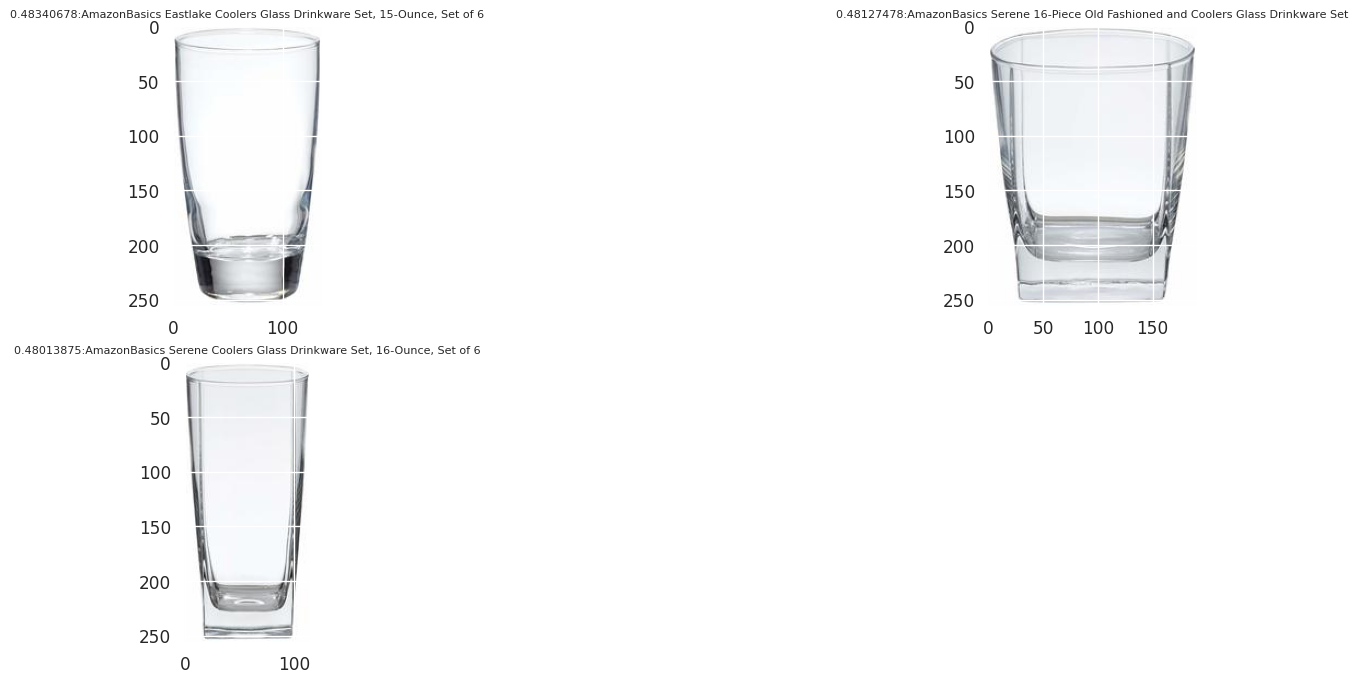

In [29]:
similar_items = find_similar_items_from_query(query_prompt = query_prompt, k=5, num_results=3, index_name=index_name, dataset = dataset, 
                                   open_search_client = os_client, image_root_path=f's3://amazon-berkeley-objects/images/small/')

display_images(similar_items)

## 5.2 이미지 입력 기반으로 이미지 검색 수행

간단한 이미지를 기반으로 결과를 살펴보겠습니다. 입력 이미지는 벡터 임베딩으로 변환되고, 유사성 검색을 기반으로 결과가 반환될 것입니다.

어떤 이미지든 사용할 수 있지만, 아래 예시에서는 위 데이터셋에서 item_id(예: item_id = "B07JCDQWM6")를 기반으로 무작위 이미지를 선택하고, 이 이미지를 검색 엔진에 보내 유사한 항목을 찾을 것입니다. 먼저 item_id를 기반으로 이미지와 이미지 위치를 가져오겠습니다.

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


Amazon Brand – Rivet Thomas Modern Leather Sofa Couch, 81.5"W, Chestnut


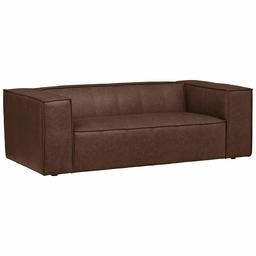

In [30]:
item_id = "B07JCDQWM6"

image, item_name = get_image_from_item_id_s3(item_id = item_id, dataset = dataset, image_path = f's3://amazon-berkeley-objects/images/small/' )
print(item_name)
image

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


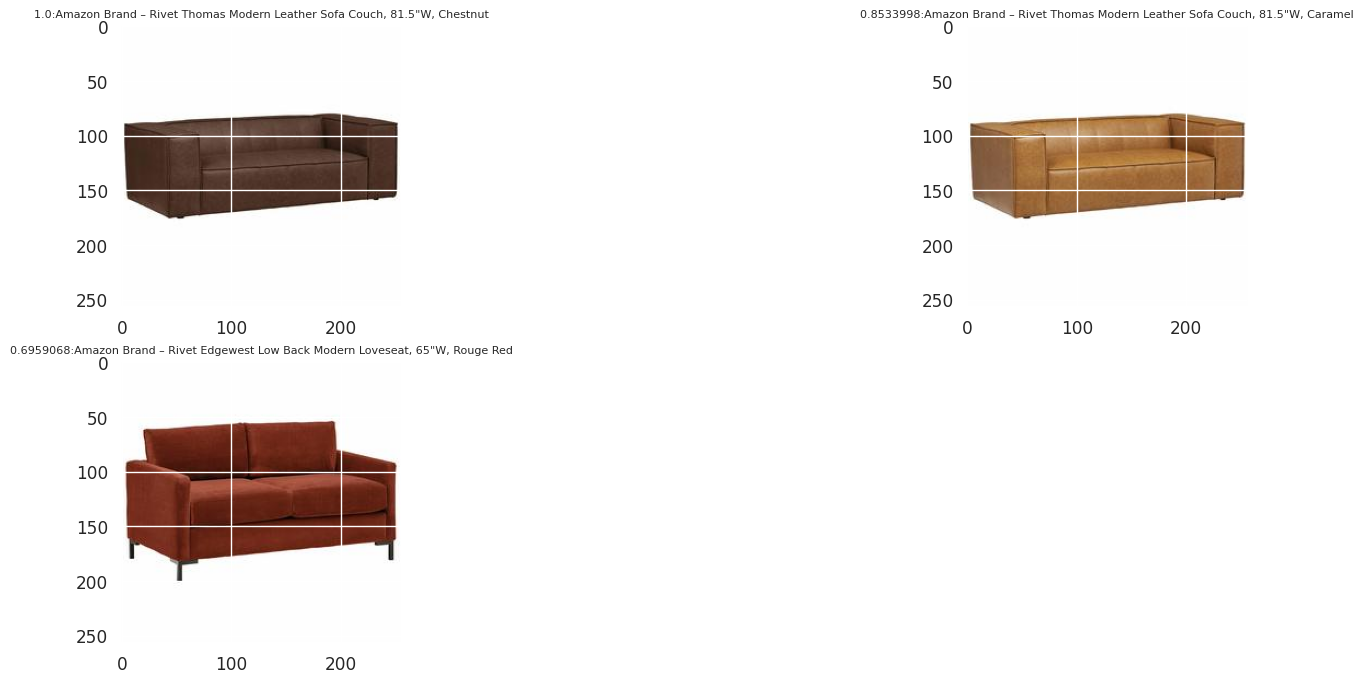

In [31]:
item_id = "B07JCDQWM6"
search_image_path = dataset[dataset['item_id']==item_id]['img_full_path'].iloc[0]

similar_items = find_similar_items_from_image(image_path = search_image_path, k=5, num_results=3, index_name=index_name, dataset = dataset, 
                                   open_search_client = os_client, image_root_path=f's3://amazon-berkeley-objects/images/small/')

display_images(similar_items)

## 6. Clean up

인덱스를 삭제를 위해서는 아래 코드의 주석을 제거하고 실행 하세요.
오픈 서치 도메인을 삭제 하기 위해서는, 오픈 서치 콘솔에 로그인해서 지우시기 바립니다.

In [ ]:
# delete vector index

# if index_exists:
#     opensearch_utils.delete_index(
#         os_client,
#         index_name
#     )
# else:
#     print(f"{index_name} does not exist")


